In [1]:
%%capture
!pip install torch transformers datasets pandas scikit-learn

# Load training data

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# download training data (labeled):
!wget https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_train.csv

# load training data:
data = pd.read_csv('incidents_train.csv', index_col=0)
data.head()


--2025-02-21 09:58:37--  https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12866710 (12M) [text/plain]
Saving to: ‘incidents_train.csv’

incidents_train.csv 100%[===================>]  12.27M  62.2MB/s    in 0.2s    

2025-02-21 09:58:38 (62.2 MB/s) - ‘incidents_train.csv’ saved [12866710/12866710]



,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_distribution(category):
  """
  A method to show the label distribution
  """
  category_counts = data[category].value_counts()
  plt.figure(figsize=(20,8))

  plt.subplot(1,2,2)
  sns.barplot(x=category_counts.index, y=category_counts.values,palette="Blues_d")
  plt.title(f"{category} Label Distribution")
  plt.xlabel(f"{category} labels")
  plt.ylabel('Count')
  plt.xticks(rotation=45)

  plt.tight_layout()
  plt.show()

<ipython-input-3-e32645c809bc>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values,palette="Blues_d")


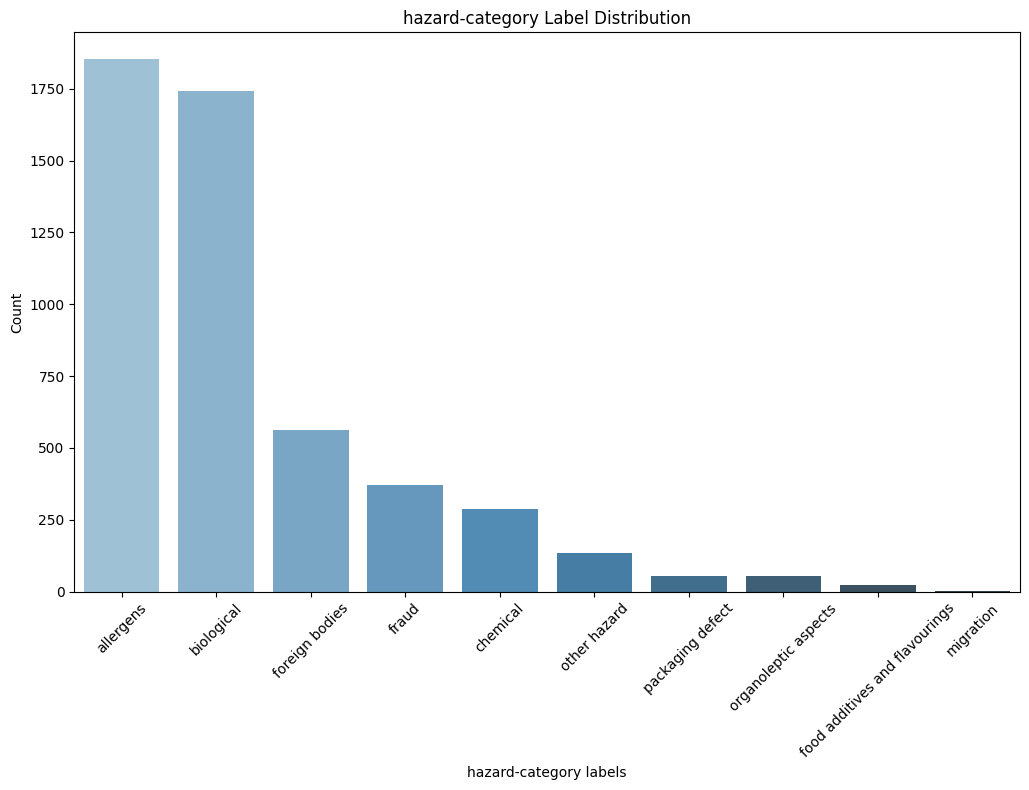

In [ ]:
draw_distribution('hazard-category')

<ipython-input-3-e32645c809bc>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values,palette="Blues_d")


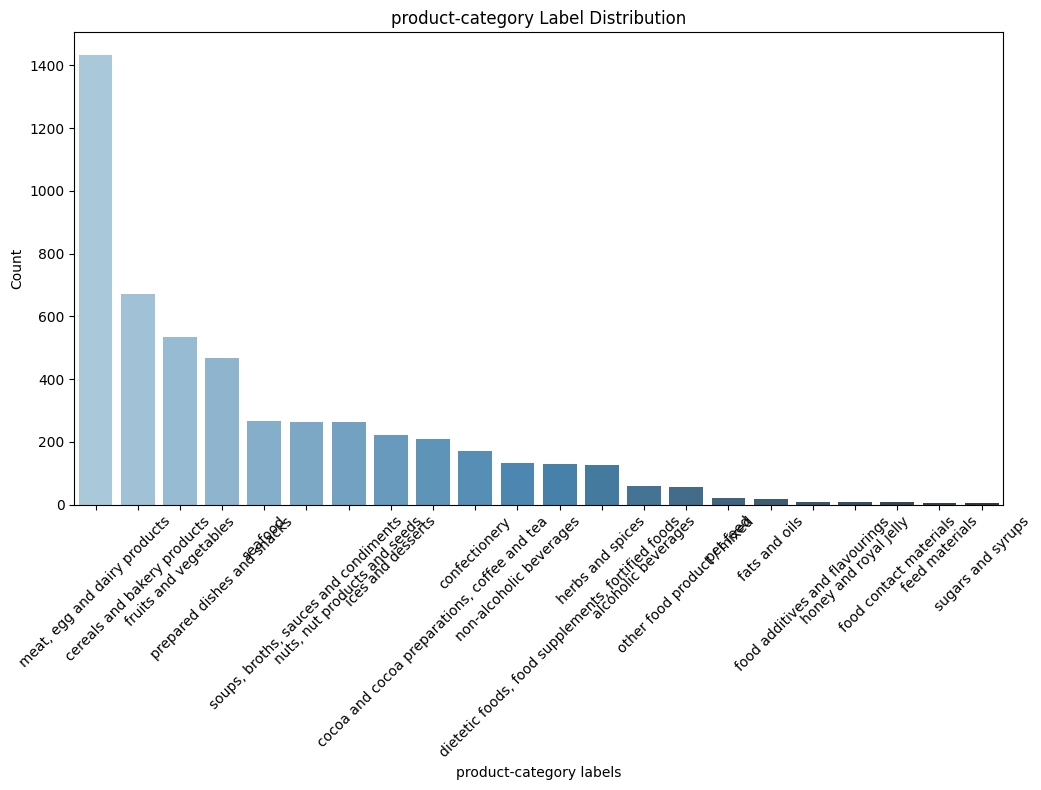

In [ ]:
draw_distribution('product-category')

#Data Augmentation

In [3]:
# long tail data： dynamic thresholding is better but without enough GPU, so choose to observation
# after observation, I decided to add 3 items to counts smaller than 10
def find_minority_label(label,df):
  minority_labels= dict()
  for l in df[label].unique():
    if len(df[df[label]==l]) < 10:
      minority_labels.update({l:len(df[df[label]==l])})
  return minority_labels


In [ ]:
def find_minority_label(label, df, threshold_ratio=0.01, min_samples=2):

    total_samples = len(df)
    threshold = max(min_samples, int(total_samples * threshold_ratio))  # Dynamic threshold

    # Compute label counts efficiently
    label_counts = df[label].value_counts()

    # Select labels below the threshold
    minority_labels = label_counts[label_counts < threshold].to_dict()

    return dict(sorted(minority_labels.items(), key=lambda x: x[1]))

In [4]:
minority_hazard = find_minority_label('hazard-category', data)
minority_hazard

{'migration': 3}

In [5]:
minority_product = find_minority_label('product-category', data)
minority_product

{'food contact materials': 7,
 'food additives and flavourings': 8,
 'sugars and syrups': 5,
 'honey and royal jelly': 8,
 'feed materials': 6}

In [6]:
#get the minority dataframe
minority_df =data[data['hazard-category'].isin(minority_hazard.keys()) | data['product-category'].isin(minority_product.keys())]
minority_df.head()

,year,month,day,country,title,text,hazard-category,product-category,hazard,product
152,2003,4,8,au,The Australian Football League—AFL 2003 Auskic...,PRA No. 2003/6086 Date published 8 Apr 2003 Pr...,other hazard,food contact materials,other not classified,plastics
615,2012,3,1,au,Frost Merchandising Pty Ltd—Smiles 4 Miles / D...,PRA No. 2012/13044 Date published 1 Mar 2012 P...,packaging defect,food contact materials,damaged packaging,plastics
983,2014,2,20,hk,Food Alert - Food Allergen Alert: Stop Consumi...,Food Alert - Food Allergen Alert: Stop Consumi...,allergens,food additives and flavourings,milk and products thereof,"emulsifiers, stabilizers, thickeners and gelli..."
1116,2014,11,6,ca,Beehive brand Corn Syrup recalled due to piece...,Notice This archive of previously issued food ...,foreign bodies,sugars and syrups,plastic fragment,syrup
1408,2015,10,24,us,2015 - UPC Correction: David Trail Mix Sweet &...,DAVID Trail Mix Sweet & Salty flavor is being ...,allergens,food additives and flavourings,milk and products thereof,flavours


In [7]:
from transformers import MarianMTModel, MarianTokenizer
target_model_name = 'Helsinki-NLP/opus-mt-en-ROMANCE'
target_tokenizer = MarianTokenizer.from_pretrained(target_model_name)
target_model = MarianMTModel.from_pretrained(target_model_name).to('cuda')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/779k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/799k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [8]:
en_model_name = 'Helsinki-NLP/opus-mt-ROMANCE-en'
en_tokenizer = MarianTokenizer.from_pretrained(en_model_name)
en_model = MarianMTModel.from_pretrained(en_model_name).to('cuda')

tokenizer_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/800k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/779k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [9]:
def translate(texts, model, tokenizer, language="fr"):
    template = lambda text: f"{text}" if language == "en" else f">>{language}<< {text}"
    src_texts = [template(text) for text in texts]

    encoded = tokenizer(src_texts, return_tensors="pt", padding=True, truncation=True).to('cuda')

    translated = model.generate(**encoded)

    translated_texts = tokenizer.batch_decode(translated, skip_special_tokens=True)

    return translated_texts

In [10]:
def back_translate(texts, source_lang="en", target_lang="fr"):
    fr_texts = translate(texts, target_model, target_tokenizer, language=target_lang)

    back_translated_texts = translate(fr_texts, en_model, en_tokenizer, language=source_lang)

    return back_translated_texts

In [11]:
texts_to_augment = minority_df['text'].tolist()
fr_augmented_texts = back_translate(texts_to_augment, source_lang="en", target_lang="fr")

In [12]:
es_augmented_texts = back_translate(texts_to_augment, source_lang="en", target_lang="es")

In [13]:
len(minority_df)

34

In [14]:
# take the place of minority and then add it to original data
fr_augmented_df = minority_df.copy()

fr_augmented_df['text'] = fr_augmented_texts
len(fr_augmented_df)

34

In [15]:
es_augmented_df = minority_df.copy()

es_augmented_df['text'] = es_augmented_texts
len(es_augmented_df)

34

In [16]:
fs_df = pd.concat([fr_augmented_df,es_augmented_df ], ignore_index=True)
len(fs_df)

68

In [17]:
len(data)

5082

In [18]:
aug_df = pd.concat([fs_df,data], ignore_index=True)
len(aug_df)

5150

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
file_path = '/content/drive/My Drive/augmented_data_2.csv'

In [21]:
aug_df.to_csv(file_path, index=False)
print(f"Data saved to {file_path}")

Data saved to /content/drive/My Drive/augmented_data_2.csv


In [22]:
import pandas as pd
aug_data = pd.read_csv(file_path)
aug_data.head()

,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,2003,4,8,au,The Australian Football League—AFL 2003 Auskic...,"APR No. 2003/6086 Release Date April 8, 2003 P...",other hazard,food contact materials,other not classified,plastics
1,2012,3,1,au,Frost Merchandising Pty Ltd—Smiles 4 Miles / D...,Product Category Foods and Groceries × Smile 4...,packaging defect,food contact materials,damaged packaging,plastics
2,2014,2,20,hk,Food Alert - Food Allergen Alert: Stop Consumi...,The CFS took a sample of Lecithin powder from ...,allergens,food additives and flavourings,milk and products thereof,"emulsifiers, stabilizers, thickeners and gelli..."
3,2014,11,6,ca,Beehive brand Corn Syrup recalled due to piece...,Notice This archive of food recalls and allerg...,foreign bodies,sugars and syrups,plastic fragment,syrup
4,2015,10,24,us,2015 - UPC Correction: David Trail Mix Sweet &...,DAVID Trail Mix Sweet & Salty Taste is volunta...,allergens,food additives and flavourings,milk and products thereof,flavours


In [23]:
len(aug_data)

5150

#Split data

In [ ]:
train_df, dev_df = train_test_split(data, test_size=0.2, random_state=2024)

train_df.sample()

In [24]:
# use augmented data
train_df, dev_df = train_test_split(aug_data, test_size=0.2, random_state=2024)

train_df.sample()

,year,month,day,country,title,text,hazard-category,product-category,hazard,product
1440,2015,9,21,au,Hemp Foods Australia Pty Ltd—Hemp Protein & He...,PRA No. 2015/14913 Date published 21 Sep 2015 ...,biological,"dietetic foods, food supplements, fortified foods",salmonella,hemp protein powder


In [ ]:
data.title.str.split().apply(len).describe()

,title
count,5082.000000
mean,13.282369
std,5.229355
min,1.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,44.000000


# Train and Evaluate BERT

In [25]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler, DataCollatorWithPadding
from functools import partial

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# def mask_keywords(text, keywords, default_prompt=None):
#     found = False
#     for keyword in keywords:
#         if keyword in text:
#             text = text.replace(keyword, "[MASK]")
#             found = True
#     if not found and default_prompt:
#         text = default_prompt + text
#     return text

# def tokenize_function(examples, label_type):
#     keywords_hazard = ['hazard', 'risk', 'danger', 'safety', 'damage','issue','defect']
#     keywords_product = ['product', 'meat','fruit','vegetables','deserts','fat','sugar']

#     if label_type == 'hazard-category':
#         default_prompt = "This text is about hazards."
#         input_text = [mask_keywords(text, keywords_hazard, default_prompt) for text in examples['text']]
#     elif label_type == 'product-category':
#         default_prompt = "This text is about products."
#         input_text = [mask_keywords(text, keywords_product, default_prompt) for text in examples['text']]

#     return tokenizer(input_text, padding='max_length', truncation=True, max_length=512)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding=True, truncation=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Data preprocessing function:

In [30]:
!pip3 install datasets

In [31]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from datasets import Dataset

def prepare_data(label):
    # encode labels:
    label_encoder = LabelEncoder()
    label_encoder.fit(aug_data[label])

    train_df['label'] = label_encoder.transform(train_df[label])
    dev_df['label'] = label_encoder.transform(dev_df[label])

    # Convert DataFrame to Hugging Face Dataset
    train_dataset = Dataset.from_pandas(train_df)
    dev_dataset = Dataset.from_pandas(dev_df)

    # Apply the tokenizer to the dataset
    # Tokenizer without prompt
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    dev_dataset = dev_dataset.map(tokenize_function, batched=True)

    # Tokenizer with prompt
    # train_dataset = train_dataset.map(partial(tokenize_function, label_type=label), batched=True)
    # dev_dataset = dev_dataset.map(partial(tokenize_function, label_type=label), batched=True)

    # Create DataCollator to handle padding
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, max_length=16)

    # Convert dataset to PyTorch format
    train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    dev_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    # Create DataLoader objects
    return (
        DataLoader(train_dataset, shuffle=True, batch_size=8, collate_fn=data_collator),
        DataLoader(dev_dataset, batch_size=8, collate_fn=data_collator),
        label_encoder
    )

Evaluation function:

In [32]:
from sklearn.metrics import f1_score

def compute_score(hazards_true, products_true, hazards_pred, products_pred):
  # compute f1 for hazards:
  f1_hazards = f1_score(
    hazards_true,
    hazards_pred,
    average='macro'
  )

  # compute f1 for products:
  f1_products = f1_score(
    products_true[hazards_pred == hazards_true],
    products_pred[hazards_pred == hazards_true],
    average='macro'
  )

  return (f1_hazards + f1_products) / 2.

In [ ]:
# focal loss function
from typing import Optional, Sequence

import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F


class FocalLoss(nn.Module):
    """ Focal Loss, as described in https://arxiv.org/abs/1708.02002.

    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.

    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(self,
                 alpha: Optional[Tensor] = None,
                 gamma: float = 0.,
                 reduction: str = 'mean',
                 ignore_index: int = -100):
        """Constructor.

        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(
                'Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(
            weight=alpha, reduction='none', ignore_index=ignore_index)

    def __repr__(self):
        arg_keys = ['alpha', 'gamma', 'ignore_index', 'reduction']
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f'{k}={v!r}' for k, v in zip(arg_keys, arg_vals)]
        arg_str = ', '.join(arg_strs)
        return f'{type(self).__name__}({arg_str})'

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return torch.tensor(0.)
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss


def focal_loss(alpha: Optional[Sequence] = None,
               gamma: float = 0.,
               reduction: str = 'mean',
               ignore_index: int = -100,
               device='cpu',
               dtype=torch.float32) -> FocalLoss:
    """Factory function for FocalLoss.

    Args:
        alpha (Sequence, optional): Weights for each class. Will be converted
            to a Tensor if not None. Defaults to None.
        gamma (float, optional): A constant, as described in the paper.
            Defaults to 0.
        reduction (str, optional): 'mean', 'sum' or 'none'.
            Defaults to 'mean'.
        ignore_index (int, optional): class label to ignore.
            Defaults to -100.
        device (str, optional): Device to move alpha to. Defaults to 'cpu'.
        dtype (torch.dtype, optional): dtype to cast alpha to.
            Defaults to torch.float32.

    Returns:
        A FocalLoss object
    """
    if alpha is not None:
        if not isinstance(alpha, Tensor):
            alpha = torch.tensor(alpha)
        alpha = alpha.to(device=device, dtype=dtype)

    fl = FocalLoss(
        alpha=alpha,
        gamma=gamma,
        reduction=reduction,
        ignore_index=ignore_index)
    return fl

In [ ]:
focal_loss_fn = FocalLoss(alpha=None, gamma=2, reduction='mean')

## Sub-Task 1:

### Label: `Hazard Category`

* Data preprocessing

In [33]:
label = 'hazard-category'

# Create DataLoader objects
train_dataloader, dev_dataloader, le_hazard_category = prepare_data(label)

Map:   0%|          | 0/4120 [00:00<?, ? examples/s]

Map:   0%|          | 0/1030 [00:00<?, ? examples/s]

* Choose your model

In [34]:
model_hazard_category = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(aug_data[label].unique()))
model_hazard_category.to('cuda')  # Move model to GPU if available

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

* Train it

In [35]:
from tqdm.auto import tqdm

optimizer = AdamW(model_hazard_category.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

model_hazard_category.train()

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to('cuda') for k, v in batch.items()}  # Move batch to GPU if available
        outputs = model_hazard_category(**batch)
        loss = outputs.loss

        # logits = outputs.logits
        # labels = batch['labels']
        # loss = focal_loss_fn(logits, labels)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1545 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


* Assess it

In [36]:
from sklearn.metrics import classification_report

model_hazard_category.eval()
total_predictions = []
with torch.no_grad():
    for batch in dev_dataloader:
        batch = {k: v.to('cuda') for k, v in batch.items()}  # Move batch to GPU if available
        outputs = model_hazard_category(**batch)
        predictions = torch.argmax(outputs.logits, dim=-1)
        total_predictions.extend([p.item() for p in predictions])

predicted_labels = le_hazard_category.inverse_transform(total_predictions)
gold_labels = le_hazard_category.inverse_transform(dev_df.label.values)
print(classification_report(gold_labels, predicted_labels, zero_division=0))

dev_df['predictions-hazard-category'] = predicted_labels


                                precision    recall  f1-score   support

                     allergens       0.94      0.98      0.96       369
                    biological       0.99      0.99      0.99       353
                      chemical       0.89      0.90      0.89        61
food additives and flavourings       0.50      0.25      0.33         4
                foreign bodies       0.98      0.97      0.97       116
                         fraud       0.82      0.65      0.72        71
                     migration       1.00      0.33      0.50         3
          organoleptic aspects       0.73      0.67      0.70        12
                  other hazard       0.61      0.71      0.66        31
              packaging defect       0.90      0.90      0.90        10

                      accuracy                           0.94      1030
                     macro avg       0.84      0.73      0.76      1030
                  weighted avg       0.94      0.94      0.94 

In [37]:
model_hazard_category.save_pretrained("bert_hazard_category")
np.save("bert_hazard_category/label_encoder.npy", le_hazard_category.classes_)

### Label: `Product Category`

In [38]:
label = 'product-category'

# Create DataLoader objects
train_dataloader, dev_dataloader, le_product_category = prepare_data(label)

Map:   0%|          | 0/4120 [00:00<?, ? examples/s]

Map:   0%|          | 0/1030 [00:00<?, ? examples/s]

* Train

In [39]:
model_product_category = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(aug_data[label].unique()))
model_product_category.to('cuda')  # Move model to GPU if available

optimizer = AdamW(model_product_category.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

model_product_category.train()
progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to('cuda') for k, v in batch.items()}  # Move batch to GPU if available
        outputs = model_product_category(**batch)
        loss = outputs.loss
        # logits = outputs.logits
        # labels = batch['labels']
        # loss = focal_loss_fn(logits, labels)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1545 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


* Test

In [40]:
model_product_category.eval()
total_predictions = []
with torch.no_grad():
    for batch in dev_dataloader:
        batch = {k: v.to('cuda') for k, v in batch.items()}  # Move batch to GPU if available
        outputs = model_product_category(**batch)
        predictions = torch.argmax(outputs.logits, dim=-1)
        total_predictions.extend([p.item() for p in predictions])

predicted_labels = le_product_category.inverse_transform(total_predictions)
gold_labels = le_product_category.inverse_transform(dev_df.label.values)
print(classification_report(gold_labels, predicted_labels, zero_division=0))

dev_df['predictions-product-category'] = predicted_labels

                                                   precision    recall  f1-score   support

                              alcoholic beverages       0.78      0.93      0.85        15
                      cereals and bakery products       0.81      0.81      0.81       135
     cocoa and cocoa preparations, coffee and tea       0.66      0.64      0.65        36
                                    confectionery       0.46      0.38      0.42        29
dietetic foods, food supplements, fortified foods       0.70      0.72      0.71        32
                                    fats and oils       0.50      0.67      0.57         3
                                   feed materials       0.00      0.00      0.00         0
                   food additives and flavourings       0.00      0.00      0.00         4
                           food contact materials       0.00      0.00      0.00         5
                            fruits and vegetables       0.78      0.85      0.82       11

In [41]:
model_product_category.save_pretrained("bert_product_category")
np.save("bert_product_category/label_encoder.npy", le_product_category.classes_)

## Evaluate Sub-Task

In [42]:
score = compute_score(
    dev_df['hazard-category'], dev_df['product-category'],
    dev_df['predictions-hazard-category'], dev_df['predictions-product-category']
)
print(f"Score Sub-Task 1: {score:.3f}")

Score Sub-Task 1: 0.698
